# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
pip install statsmodels --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: statsmodels in /home/jovyan/.local/lib/python3.7/site-packages (0.13.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [5]:
data.sort_index(inplace=True)
data = data.resample('H').sum()
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [6]:
data.isna().sum()

num_orders    0
dtype: int64

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [8]:
data.query('num_orders >= 107').head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 22:00:00,113
2018-03-02 01:00:00,120
2018-03-02 22:00:00,119
2018-03-03 00:00:00,163


I have data from 2018-03-01 00:00:00 to 2018-08-31 23:50:00
first the data is arranged by ten minutes, I want to predict the next hour so I re-sample by one hour, no missing values, no negative values, 4416 consecutive hours of data when the average number of trips per hour is 84 with a standard deviation of 45 which is quite large 53 percent of the average, 25 percent of the data is greater than 170 orders and I can already see that between 22:00 and 01:00 these are more active hours.

## Analysis

In [9]:
data['rolling_mean'] = data.shift(1).rolling(12).mean()
data['rolling_std'] = data['num_orders'].shift(1).rolling(12).std()
data = data.dropna()

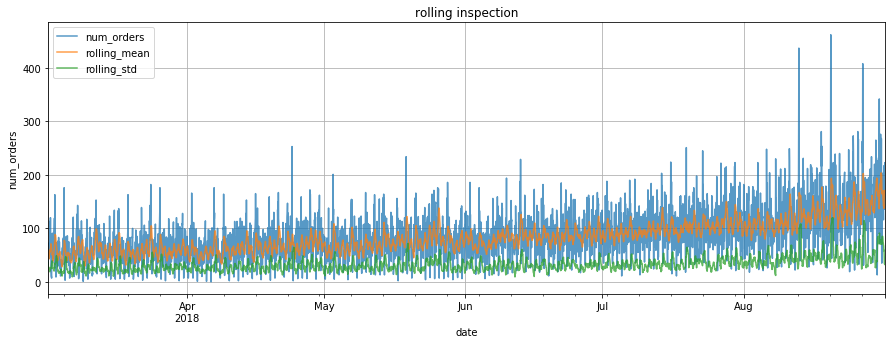

In [10]:
data.plot(grid=True,alpha=0.75,figsize=(15,5))
plt.title('rolling inspection')
plt.xlabel('date')
plt.ylabel('num_orders');

I can't really see anything from these plot, only it seems that the total number of trips is increasing towards August, and in August it breaks records, which means I have a non stationary timr line, the average in August is different from the average in March, if we look at the orange line which is the rolling mean we can see that it constantly strives to reach the 100 orders line, in July it actually crosses the line and in August it is already above the line.

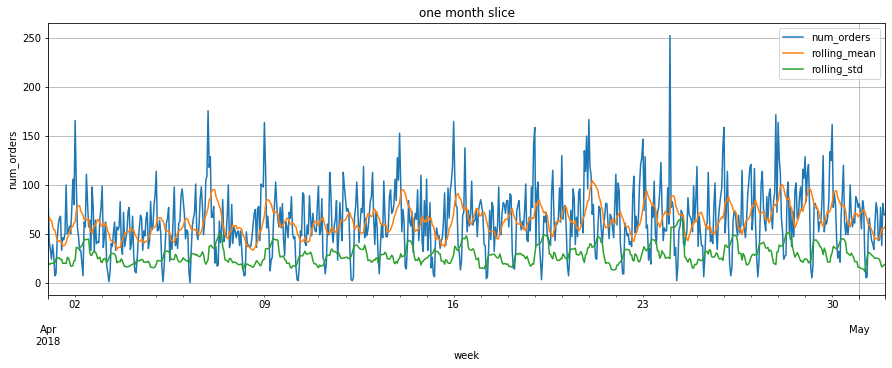

In [11]:
data['2018-04-01':'2018-05-01'].plot(grid=True,figsize=(15,5))
plt.title('one month slice')
plt.xlabel('week')
plt.ylabel('num_orders');

As I slash into smaller pieces the pattern becomes clearer, and it seems that weekends are more active.

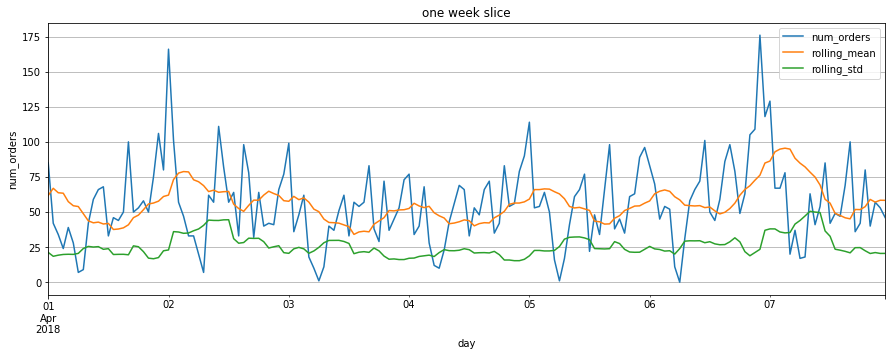

In [12]:
data['2018-04-01':'2018-04-07'].plot(grid=True,figsize=(15,5))
plt.title('one week slice')
plt.xlabel('day')
plt.ylabel('num_orders');

Here we already can really see the pattern and seasonality, sharp jumps can be seen in the late hours of the night and early in the morning especially on weekends or early in the week, when in fact the biggest fall of each day is at six in the morning.

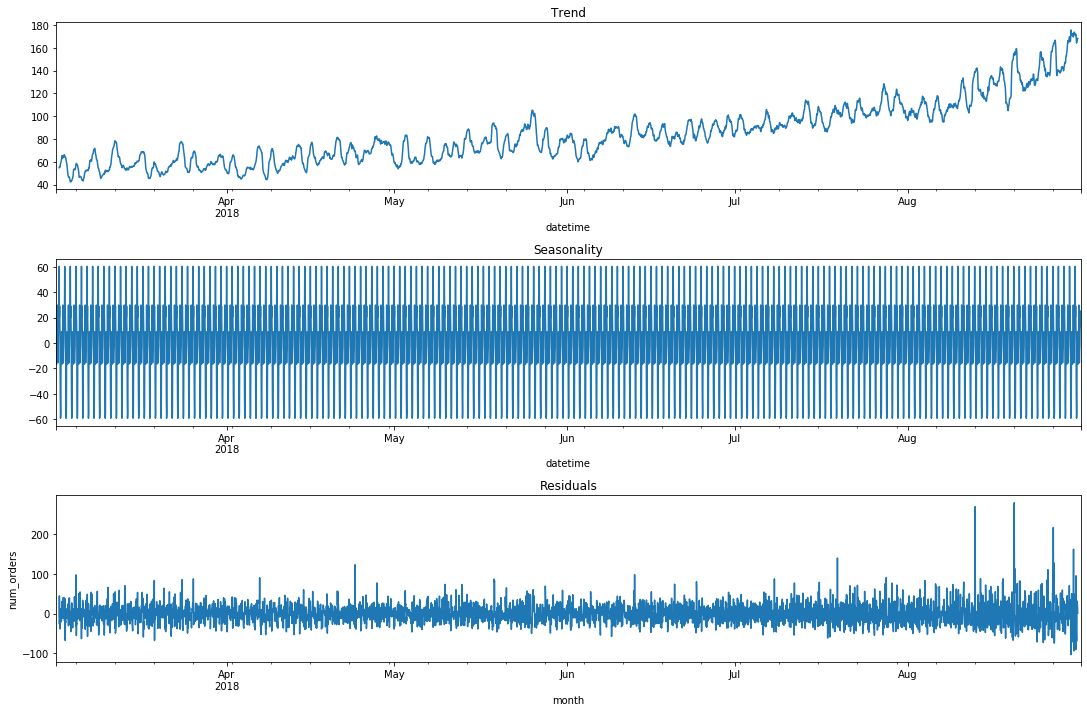

In [13]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.xlabel('month')
plt.ylabel('num_orders');

There is no obvious trend, yes there is a moderate increase throughout the year, the seasonality is clear and constant throughout all the data

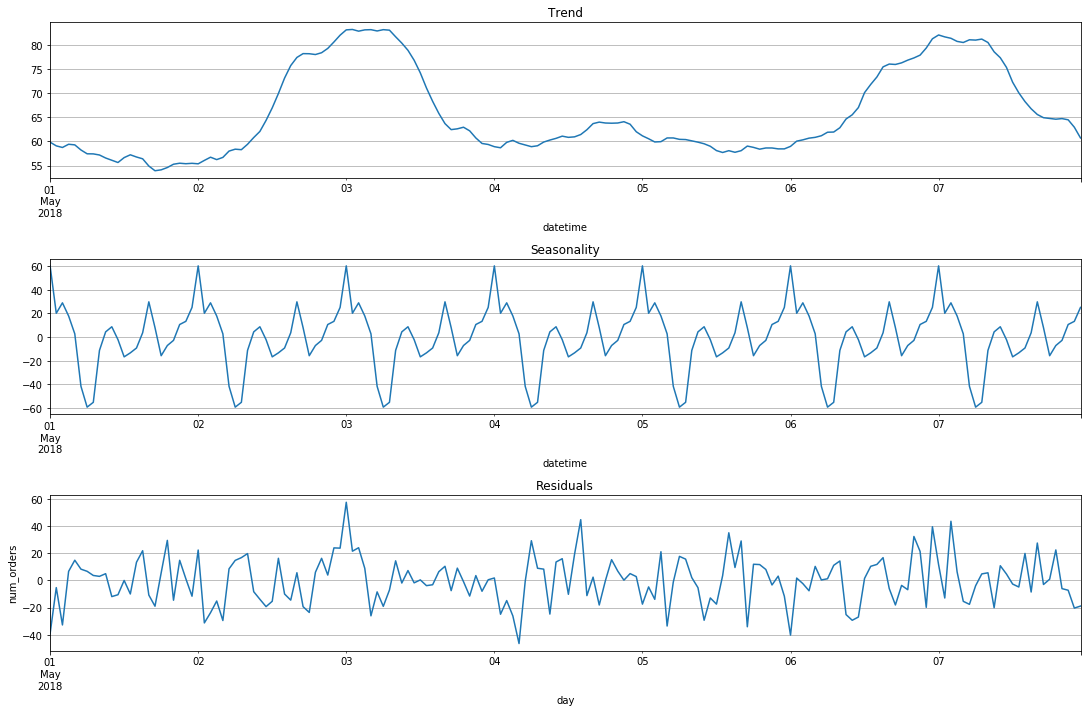

In [14]:
#decomposed = seasonal_decompose(data['num_orders']['2018-05-01':'2018-05-07'])

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed.trend['2018-05-01':'2018-05-07'].plot(ax=plt.gca(),grid=True)
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-07'].plot(ax=plt.gca(),grid=True)
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-05-01':'2018-05-07'].plot(ax=plt.gca(),grid=True)
plt.title('Residuals')
plt.tight_layout()
plt.xlabel('day')
plt.ylabel('num_orders');

The trend I do not know what to conclude from it I see a big increase on the third day of the week and then a decrease and treading during the week and again an increase during the weekend, The seasonality is very clear with high ascents at night 00:00 while the largest descents in the morning 06:00 regular and clear recurrence throughout the week and the data

In [15]:
#stationary time serie
data['difference'] = data['num_orders'] - data['num_orders'].shift(fill_value=0)
#data['mean_difference'] = data['difference'].rolling(12).mean()
#data['std_difference'] = data['difference'].rolling(12).std()
data

,num_orders,rolling_mean,rolling_std,difference
datetime,,,,
2018-03-01 12:00:00,30,57.083333,36.154865,30
2018-03-01 13:00:00,32,49.250000,29.997348,2
2018-03-01 14:00:00,48,44.833333,28.096695,16
2018-03-01 15:00:00,66,42.916667,26.908797,18
2018-03-01 16:00:00,43,42.916667,26.908797,-23
...,...,...,...,...
2018-08-31 19:00:00,136,163.416667,48.899634,-71
2018-08-31 20:00:00,154,170.916667,33.835050,18
2018-08-31 21:00:00,159,168.583333,33.966450,5


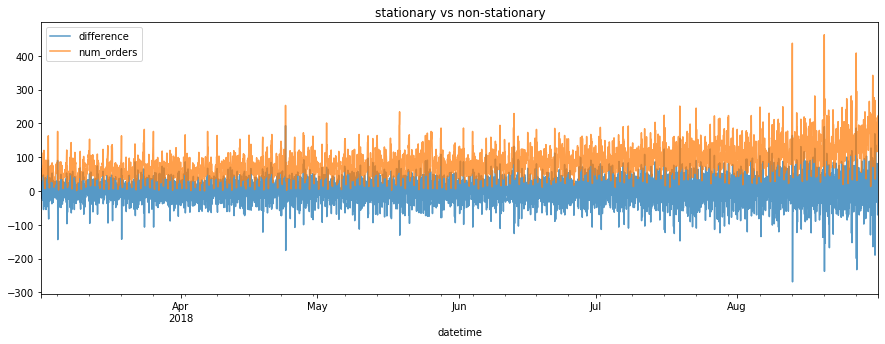

In [16]:
data[['difference','num_orders']].plot(alpha=0.75,figsize=(15,5))
plt.title('stationary vs non-stationary');

My data is non-stationary by converting it to a stationary time line, it can sometimes improve the prediction, we will later check the correlation with the target

**Creating Features**

In [17]:
def make_features(data, max_lag):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data.dropna(inplace=True)

In [18]:
make_features(data, 12)
data.columns

Index(['num_orders', 'rolling_mean', 'rolling_std', 'difference', 'month',
       'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12'],
      dtype='object')

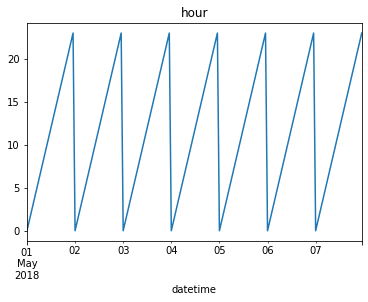

In [19]:
data['hour']['2018-05-01':'2018-05-07'].plot()
plt.title('hour');

The parameters I was able to extract are month, day, day of the week and hour. Because all the data from 2018 feature year is irrelevant. I chose to add 12 legs for reasons of running time and features amount, I do not want too much noise, more can be added.


The parameters I was able to extract are:

Cyclical Features - 
 - month
 - day
 - day of the week 
 - hour
 
Because all the data is from 2018, feature year is irrelevant.

Lag Features - 
- 12 legs

I chose to add 12 legs for reasons of running time and features amount, I do not want to much noise, more can be added.

Rolling Features - 
- rolling mean
- rolling std

The rolling features were calculated with shift(), therefore do not constitute data leakage

**Corr**

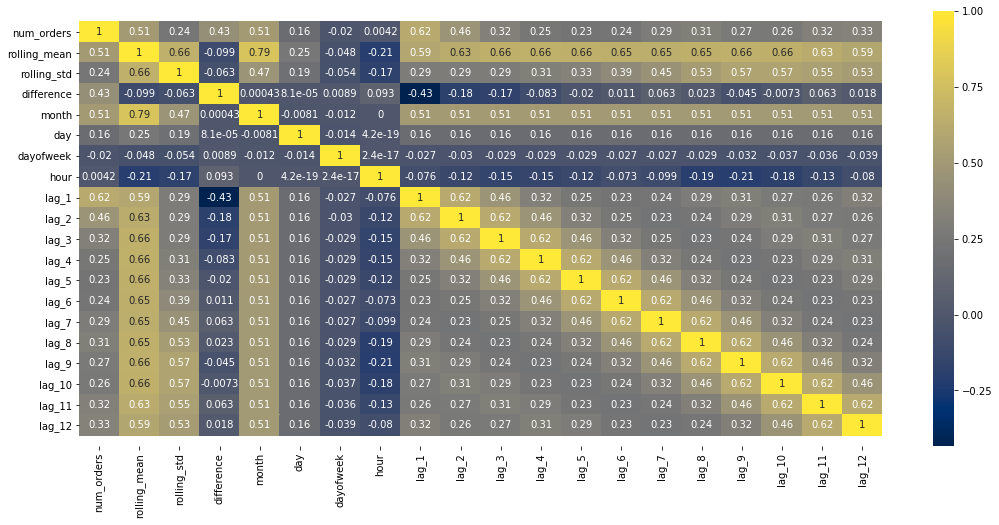

In [20]:
plt.figure(figsize=(18,8))
ax = sns.heatmap(data.corr(), annot=True, cmap='cividis')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
plt.yticks(rotation=0);

In this correlation graph we can see a healthy correlation between rolling mean and num_orders (0.51) while the correlation with rolling std is only (0.24), between the target and leg 1 the correlation is (0.62) and starts to go down to leg 5 (0.23) hence it goes up slightly to leg 8 (0.31) and goes down again to leg 10 (0.26) and rise again to (0.33) at leg 12, interesting, 
I expected the correlation between day, dayofweek and hour, and the target num_orders will be higher  
but since they are not numerical features, these are cyclical features, Pearson Correlation will not accurately reflect the true correlation of these features with the target.

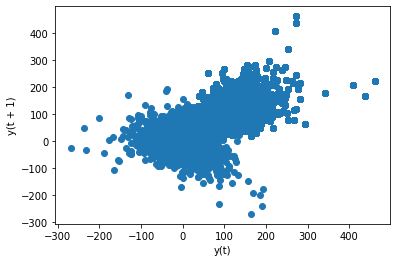

In [21]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(data)
pyplot.show()

In [22]:
data = data.drop('difference',axis=1)
data.head(2)

,num_orders,rolling_mean,rolling_std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,56.583333,22.386921,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0
2018-03-02 01:00:00,120,61.583333,22.609163,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0


I have to drop 'difference' in thise point to avoid data leakage, because it consists of the current target less the previous target, and if we do not have the current target we can not use the difference

**Train test split**

In [23]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders',axis=1)
Y_train = train['num_orders']
X_test = test.drop('num_orders',axis=1)
Y_test = test['num_orders']

**RMSE calcoletion**

In [24]:
def RMSE(true,predi):
    rmse = mean_squared_error(true,predi)
    rmse = rmse ** 0.5
    return rmse

# Model's Tuning

I will use four models of four different types:
- Random Forest Regressor
- Linear Regression
- XGBoost
- Autoregressive (AR)

Each of them will be tuning

**Random Forest Regressor**

In [25]:
grid_RF = {'n_estimators' : [100,200,300],
           'max_depth' : [None,4,6]
          }

In [26]:
model_RF = RandomForestRegressor()

In [27]:
GridSearch_RF = GridSearchCV(estimator = model_RF, param_grid = grid_RF, scoring=make_scorer(RMSE),cv=TimeSeriesSplit(n_splits=5))
GridSearch_RF.fit(X_train, Y_train)
print('The best hyperparameters are: {}'.format(GridSearch_RF.best_estimator_))
print('RMSE score is: ',GridSearch_RF.best_score_)

The best hyperparameters are: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RMSE score is:  30.059051747578625


**Linear Regression**

In [28]:
grid_LR = {}

In [29]:
model_LR = LinearRegression()

In [30]:
GridSearch_LR = GridSearchCV(estimator = model_LR, param_grid = grid_LR, scoring=make_scorer(RMSE),cv=TimeSeriesSplit(n_splits=5))
GridSearch_LR.fit(X_train, Y_train)
print('The best hyperparameters are: {}'.format(GridSearch_LR.best_estimator_))
print('RMSE score is: ',GridSearch_LR.best_score_)

The best hyperparameters are: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE score is:  31.243998156678785


**XGBoost**

In [31]:
grid_XGB = {'learning_rate': [0.1,0.2,0.3],
            'n_estimators': [250,350,450],
            'base_score': [0.25, 0.5, 0.75]
          } 

In [32]:
model_XGB = XGBRegressor()

In [33]:
GridSearch_XGB = GridSearchCV(estimator = model_XGB, param_grid = grid_XGB, scoring=make_scorer(RMSE),cv=TimeSeriesSplit(n_splits=5))
GridSearch_XGB.fit(X_train, Y_train)
print('The best hyperparameters are: {}'.format(GridSearch_XGB.best_estimator_))
print('RMSE score is: ',GridSearch_XGB.best_score_)

[18:13:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

**Autoregressive (AR)**

In [34]:
train_AR, valid_AR = train_test_split(train, shuffle=False, test_size=0.2)

In [35]:
train_AR.shape
valid_AR.shape

(791, 19)

In [36]:
legs = [12,24,50,70,100,1000]

for leg in legs:
    print('RMSE scor fot {} legs: '.format(leg))
    model_AR = sm.tsa.AutoReg(train_AR.num_orders, leg).fit()
    AR_predi = model_AR.model.predict(model_AR.params, start=valid_AR.index.min(), end=valid_AR.index.max())
    print(RMSE(valid_AR.num_orders,AR_predi))

RMSE scor fot 12 legs: 
55.044848184478354
RMSE scor fot 24 legs: 
52.39371788551705
RMSE scor fot 50 legs: 
47.2471216597984
RMSE scor fot 70 legs: 
47.97845922513973
RMSE scor fot 100 legs: 
42.26132981667996
RMSE scor fot 1000 legs: 
33.227562376178845


Random Forest Regressor - worked pretty good with RMSE score of 30.0

Linear Regression - worked slightly better with RMSE score of 31.2

XGBoost - with RMSE of 26.8 better then the random forest

Autoregressive (AR) - worked less well than I thought with an 33 RMSE score result

## Testing

Final test for adjusted models on test data set

**Random Forest Regressor**

In [37]:
best_RF = RandomForestRegressor(max_depth=4, n_estimators=300).fit(X_train,Y_train)
test_predi_RF = best_RF.predict(X_test)
print('test set RMSE: ',RMSE(Y_test,test_predi_RF))

test set RMSE:  57.73316855622165


**Linear Regression**

In [38]:
best_LR =LinearRegression().fit(X_train,Y_train)
test_predi_LR = best_LR.predict(X_test)
print('test set RMSE: ',RMSE(Y_test,test_predi_LR))

test set RMSE:  52.744986584216456


**XGBoost**

In [39]:
best_XGB = XGBRegressor(base_score=0.5, learning_rate=0.3, n_estimators=250).fit(X_train,Y_train)
test_predi_XGB = best_XGB.predict(X_test)
print('test set RMSE: ',RMSE(Y_test,test_predi_XGB))

[18:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test set RMSE:  41.74431124100933


**Autoregressive (AR)**

In [40]:
best_AR = sm.tsa.AutoReg(train.num_orders, 1000).fit()
test_predi_AR = best_AR.model.predict(best_AR.params, start=test.index.min(), end=test.index.max())
print('test set RMSE: ',RMSE(Y_test,test_predi_AR))

test set RMSE:  41.87321615121047


# conclusion

Overall the data was clean, with no missing values, no negative values, from 2018-03-01 00:00:00 to 2018-08-31 23:50:00, 4416 consecutive hours. The seasonality is clear from the beginning and there is a uniform steady and moderate upward tendency towards August. The data is not stationary and does not need to be converted to a stationary. models Random Forest Regressor and Linear Regression Worked but did not get good enough results with RMSE on a test set over 50. XGBoost and Autoregressive provided good enough results with RMSE scor of 41.8 for the Autoregressive model and 41.7 for the XGBoost model.
XGBoost is oure big winner!